<h3 style="text-align: center;"><b>NLP Final Exam</b></h3>


In [1]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Дисклеймер про CrossEntropyLoss и NLLLoss

Обычно в PyTorch не нужно делать Softmax как последний слой модели. 

* Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)
* Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss

Зачем такие сложности, чтобы посчитать обычную кросс энтропию? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность. 

Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В notebook используется лосс CrossEntropy

# Задание 1. Создайте генератор батчей. 

В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении. 

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch). Необходимо написать именно генератор, то есть вместо return использовать yield. 

Хорошая статья про генераторы: https://habr.com/ru/post/132554/


**Ответ на задание - код**


In [2]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    lenX = len(X)
    perm = np.random.permutation(lenX)
    for j in range(0, lenX, batch_size):
        jBatched = j + batch_size
        idx = perm[j:jBatched]
        X_batch = X[idx]
        y_batch = y[idx]
        yield X_batch, y_batch

Попробуем потестировать наш код

In [3]:
from inspect import isgeneratorfunction
assert isgeneratorfunction(batch_generator), "batch_generator должен быть генератором! В условии есть ссылка на доки"

X = np.array([
              [1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]
])
y = np.array([
              1, 2, 3
])

# Проверим shape первого батча
iterator = batch_generator(X, y, 2)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (2, 3), y_batch.shape == (2,)
assert np.allclose(X_batch, X[:2]), np.allclose(y_batch, y[:2])

# Проверим shape последнего батча (их всего два)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (1, 3), y_batch.shape == (1,)
assert np.allclose(X_batch, X[2:]), np.allclose(y_batch, y[2:])

# Проверим, что итерации закончились
iter_ended = False
try:
    next(iterator)
except StopIteration:
    iter_ended = True
assert iter_ended

# Еще раз проверим то, сколько батчей создает итератор
X = np.random.randint(0, 100, size=(1000, 100))
y = np.random.randint(-1, 1, size=(1000, 1))
num_iter = 0
for _ in batch_generator(X, y, 3):
    num_iter += 1
assert num_iter == (1000 // 3 + 1)

# Задание 2. Обучите модель для классификации звезд

Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

В датасете классы представлены строками, поэтому классы нужно закодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число. Кроме того, за вас мы выделили признаки, которые нужно использовать.

### Загрузка и обработка данных

In [4]:
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

In [5]:
data = pd.read_csv('https://drive.google.com/uc?id=1K-8CtATw6Sv7k2dXco1fL5MAhTbKtIH3')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [6]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [7]:
# Extract Features

X = np.array(data[feature_columns])
print(X)
# Extract target
y1 = data['class']
# encode target with target_mappingy 
y1 = np.array(y1.replace(target_mapping))
y = []
for i in  range (len(y1)):
    if (y1[i] == 0):
        y.append([0,0,1])
    if (y1[i] == 1):
        y.append([0,1,0])
    if (y1[i] == 2):
        y.append([1,0,0])


[[1.83531326e+02 8.96930300e-02 1.94740600e+01 ... 7.52000000e+02
  4.00000000e+00 2.67000000e+02]
 [1.83598371e+02 1.35285032e-01 1.86628000e+01 ... 7.52000000e+02
  4.00000000e+00 2.67000000e+02]
 [1.83680207e+02 1.26185092e-01 1.93829800e+01 ... 7.52000000e+02
  4.00000000e+00 2.68000000e+02]
 ...
 [1.31552562e+02 5.16669864e+01 1.87581800e+01 ... 1.34500000e+03
  3.00000000e+00 1.62000000e+02]
 [1.31477151e+02 5.17530678e+01 1.88828700e+01 ... 1.34500000e+03
  3.00000000e+00 1.63000000e+02]
 [1.31665012e+02 5.18053075e+01 1.92758600e+01 ... 1.34500000e+03
  3.00000000e+00 1.63000000e+02]]


Нормализация фичей

In [8]:
# Просто вычтите среднее и поделитe на стандартное отклонение (с помощью пандас). Также преобразуйте всё в np.array
X_mean = np.mean(X, axis = 0)
print(X_mean)
X_std = np.std(X, axis = 0)
X = np.array((X - X_mean)/X_std)

[175.52998658  14.83614798  18.61935536  17.37193149  16.84096332
  16.58357925  16.42283316 981.0348       3.6487     302.3801    ]


In [9]:
X.shape

(10000, 10)

In [10]:
'''assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы''''
#представляла маппингш в другой форме, поэтому закоментила 

SyntaxError: EOL while scanning string literal (<ipython-input-10-47b5bb8ac360>, line 4)

Обучение

In [11]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

Хорошо, данные мы подготовили, теперь надо объявить модель

In [22]:
torch.manual_seed(42) 
np.random.seed(42)
input_size = len(X[0])
output_size = 3 
model = nn.Sequential(
    nn.Linear(input_size, 50),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(100),
    nn.Linear(100, output_size))
loss_fn = torch.nn.MSELoss()
optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
X_train1 = torch.tensor(X_train).float()
y_train1 = torch.tensor(y_train).float()

C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [24]:
print(X_train1)

tensor([[ 0.0799, -0.6470, -2.7026,  ...,  0.9146,  1.4113, -1.4479],
        [-1.0314,  1.3169,  0.9584,  ...,  1.3318, -0.3894, -1.0665],
        [ 0.1399, -0.6095, -0.8586,  ..., -0.8234, -0.9896,  0.8650],
        ...,
        [ 1.2690,  1.4768,  0.7891,  ...,  1.3318, -1.5898,  1.5416],
        [ 1.3397, -0.5920, -1.6199,  ..., -0.8637, -0.3894,  1.4617],
        [-0.9814,  1.3838,  0.5730,  ...,  1.3318, -0.3894, -0.9681]])


In [25]:
print(len(X[0]))

10


In [26]:
len(X_train1)

7500

In [27]:
len(y_train1)

7500

In [28]:
X_test1 = torch.tensor(X_test).float()
y_test1 = torch.tensor(y_test).float()

C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


### Обучающий цикл

In [29]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        
        
        
        
        for X_batch, y_batch in batch_generator(X_train1, y_train1, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            y_pred1 = model(X_batch)
            
            
            
            
            
            # Посчитаем предсказание и лосс
            loss = loss_fn(y_pred1, y_batch)
            
            # зануляем градиент
            optimizer.zero_grad()
            
            # backward
            loss.backward()
            
            # ОБНОВЛЯЕМ веса
            optimizer.step()
            
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(loss.item())  
        if (i%10 == 0):
            print(i, loss.item())
        train_losses.append(np.mean(epoch_train_losses))
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            y_test_pred = model(X_test1)
            y_pred = model(X_train1)
            loss2 = loss_fn(y_test_pred, y_test)
            
            # Сюда опять же надо положить именно число равное лоссу на всем тест датасете
            test_losses.append(loss2)
            
    return train_losses, test_losses, y_pred, y_test_pred

In [30]:
def check_loss_decreased():
    print("На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]")
    s = input()
    if s.lower() == 'да':
        print("Хорошо!")
    else:
        raise RuntimeError("Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc")

0 0.442222535610199
10 0.16354240477085114
20 0.11877316236495972
30 0.0846242755651474
40 0.07100606709718704
50 0.06067203730344772
60 0.05662458762526512
70 0.054176438599824905
80 0.04833385348320007
90 0.045749954879283905
100 0.03943672776222229
110 0.04371635988354683
120 0.04242263734340668
130 0.042774397879838943
140 0.042332906275987625
150 0.046792250126600266
160 0.04057278856635094
170 0.03943905234336853
180 0.03706446662545204
190 0.03936509042978287
200 0.03676683455705643
210 0.040415193885564804
220 0.033192094415426254
230 0.03609510883688927
240 0.0365455225110054
250 0.03325147554278374
260 0.036570530384778976
270 0.03680666536092758
280 0.03712522238492966
290 0.03435473144054413


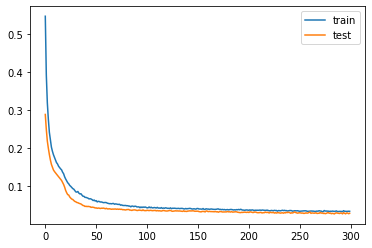

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


In [31]:
train_losses, test_losses,y_pred, y_test_pred = train(X_train, y_train, X_test, y_test,300) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

In [32]:
y_pred

tensor([[0.0192, 0.8794, 0.0987],
        [0.0189, 0.8779, 0.1004],
        [0.0180, 0.8820, 0.0971],
        ...,
        [0.0319, 0.0665, 0.9068],
        [0.0231, 0.8826, 0.0919],
        [0.0241, 0.8445, 0.1289]])

### Вычислите accuracy получившейся модели на train и test

In [33]:
from sklearn.metrics import accuracy_score

model.eval()
train_pred_labels = (np.round((y_pred).detach().numpy()))**2
test_pred_labels = (np.round((y_test_pred)).detach().numpy())**2


In [34]:
train_pred_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [35]:
y_train5 =  y_train.detach().numpy()

In [36]:
y_train5

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]], dtype=int64)

In [37]:
np.array(train_pred_labels)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [38]:
y_test5 =  y_test.detach().numpy()

In [40]:
y_test5

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=int64)

In [41]:
test_pred_labels

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [39]:
train_acc0 = accuracy_score(np.array(train_pred_labels[0]), np.array(y_train5[0]))
train_acc1 = accuracy_score(train_pred_labels[1], y_train5[1])
train_acc2 = accuracy_score(train_pred_labels[2], y_train5[2])
train_acc = ((train_acc0+train_acc1+train_acc2)/3)
test_acc0 = accuracy_score(np.array(test_pred_labels[0]), np.array(y_test5[0]))
print(train_acc0)
test_acc1 = accuracy_score(test_pred_labels[1], y_test5[1])
test_acc2 = accuracy_score(test_pred_labels[2], y_test5[2])
test_acc = ((test_acc0+test_acc1+test_acc2)/3)
print(test_acc)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

1.0
0.7777777777777778


AssertionError: Новые звезды тоже надо классифицировать хотя бы в 90% случаев

# Задание 3. Исправление ошибок в архитектуре

Только что вы обучили полносвязную нейронную сеть. Теперь вам предстоит проанализировать архитектуру нейронной сети ниже, исправить в ней ошибки и  обучить её с помощью той же функции train. Пример исправления ошибок есть в семинаре Григория Лелейтнера.

Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).

Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:

1. Если вы видите лишний нелинейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сделать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 



Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

**Ответ на задачу - средний лосс на тестовом датасете**

In [ ]:
''''torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model10 = nn.Sequential(
    #nn.Dropout(p=0.5),
    nn.Linear(input_size, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(50, 200),
    nn.Softmax(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    #nn.Dropout(p=0.5)
)

loss_fn = torch.nn.MSELoss()
optimizer =torch.optim.Adam(model.parameters(), lr=1e-2)''''


In [67]:
# RIGHT ARCH
torch.manual_seed(42)   
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(input_size, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(50, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
)


loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Обучите и протестируйте модель так же, как вы это сделали в задаче 2. Вычислите accuracy.

0 0.2240518182516098
10 0.1354074776172638
20 0.10118376463651657
30 0.07913483679294586
40 0.0607973113656044
50 0.05094020441174507
60 0.04514600709080696
70 0.0442206971347332
80 0.043138813227415085
90 0.04071134328842163
100 0.03799097612500191
110 0.036824118345975876
120 0.03873009979724884
130 0.03256331756711006
140 0.03289938345551491
150 0.0331733375787735
160 0.034503430128097534
170 0.030643094331026077
180 0.03310650214552879
190 0.03304287791252136
200 0.031195208430290222
210 0.029463307932019234
220 0.03174661844968796
230 0.03029574267566204
240 0.02760087139904499
250 0.02843572199344635
260 0.029033301398158073
270 0.027628084644675255
280 0.029087653383612633
290 0.027770398184657097
300 0.02663387544453144
310 0.026854148134589195
320 0.02888316847383976
330 0.0286750216037035
340 0.028316790238022804
350 0.026567533612251282
360 0.03276530280709267
370 0.02739877626299858
380 0.027065526694059372
390 0.027538063004612923
400 0.026123490184545517
410 0.02746730484

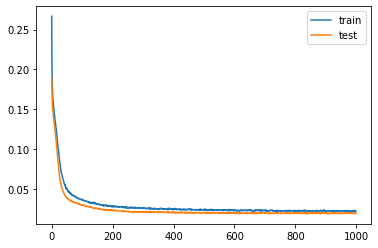

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


In [68]:
train_losses, test_losses,y_pred_new, y_test_pred_new = train(X_train1, y_train1, X_test1, y_test1, 1000) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

In [69]:
train_pred_labels = (np.round((y_pred_new).detach().numpy()))**2
test_pred_labels = (np.round((y_test_pred_new)).detach().numpy())**2
train_acc0 = accuracy_score(np.array(train_pred_labels[0]), np.array(y_train5[0]))
train_acc1 = accuracy_score(train_pred_labels[1], y_train5[1])
train_acc2 = accuracy_score(train_pred_labels[2], y_train5[2])
train_acc = ((train_acc0+train_acc1+train_acc2)/3)
test_acc0 = accuracy_score(np.array(test_pred_labels[0]), np.array(y_test5[0]))
print(train_acc0)
test_acc1 = accuracy_score(test_pred_labels[1], y_test5[1])
test_acc2 = accuracy_score(test_pred_labels[2], y_test5[2])
test_acc = ((test_acc0+test_acc1+test_acc2)/3)
print(test_acc)


assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"


1.0
0.7777777777777778


AssertionError: Новые звезды тоже надо классифицировать хотя бы в 90% случаев

In [ ]:
X_train

## Задание 4. Опишите в чем заключались ошибки

## Задание 5. Опишите модель лематизации 
Необходимо описать пошагово на примере реализацию с помощью архитектуры Transformer состоящей из Encoder и Decoder